In [1]:
## Imports and load data
import pandas as pd
import numpy as np
import glob
import gc

from scipy.stats import ks_2samp, wasserstein_distance

import matplotlib.pyplot as plt
# avoid seaborn heatmap to reduce memory spikes

# Deterministic sampling per partition
SAMPLE_FRAC = 0.01  # 1% sample per file

files = sorted(glob.glob("../data/nyc_taxi/yellow_tripdata_*.csv"))

dfs = []
for f in files:
    month = f.split("_")[-1].replace(".csv", "")
    df_m = pd.read_csv(
        f,
        usecols=["trip_distance", "fare_amount", "total_amount", "passenger_count"]
    )
    df_m = df_m.sample(frac=SAMPLE_FRAC, random_state=42)
    df_m["partition"] = month
    dfs.append(df_m)

df = pd.concat(dfs, ignore_index=True)
print("Sampled rows:", len(df))
gc.collect()
df.head()

Sampled rows: 472489


,passenger_count,trip_distance,fare_amount,total_amount,partition
0,1,1.30,6.0,7.30,2015-01
1,2,3.86,19.0,23.76,2015-01
2,1,1.10,5.5,6.36,2015-01
3,1,0.95,8.5,9.30,2015-01
4,1,1.30,7.0,8.30,2015-01


In [2]:

## Ingestion Drift Metrics
ingestion_metrics = []

for p, g in df.groupby("partition"):
    ingestion_metrics.append({
        "partition": p,
        "rows": len(g),
        "missing_rate": g.isna().mean().mean(),
        "avg_trip_distance": g["trip_distance"].mean()
    })

ingest_df = pd.DataFrame(ingestion_metrics)
ingest_df


,partition,rows,missing_rate,avg_trip_distance
0,2015-01,127490,0.0,2.794001
1,2016-01,109069,0.0,2.903486
2,2016-02,113820,0.0,2.846650
3,2016-03,122110,0.0,9.481320


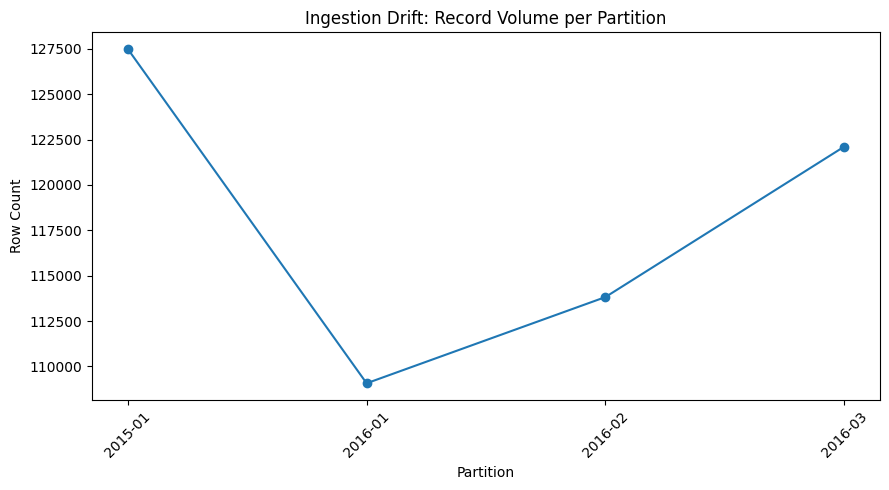

In [3]:

## Ingestion Drift Visualization
plt.figure(figsize=(9, 5))
plt.plot(ingest_df["partition"], ingest_df["rows"], marker="o")
plt.xticks(rotation=45)
plt.title("Ingestion Drift: Record Volume per Partition")
plt.ylabel("Row Count")
plt.xlabel("Partition")
plt.tight_layout()
plt.show()


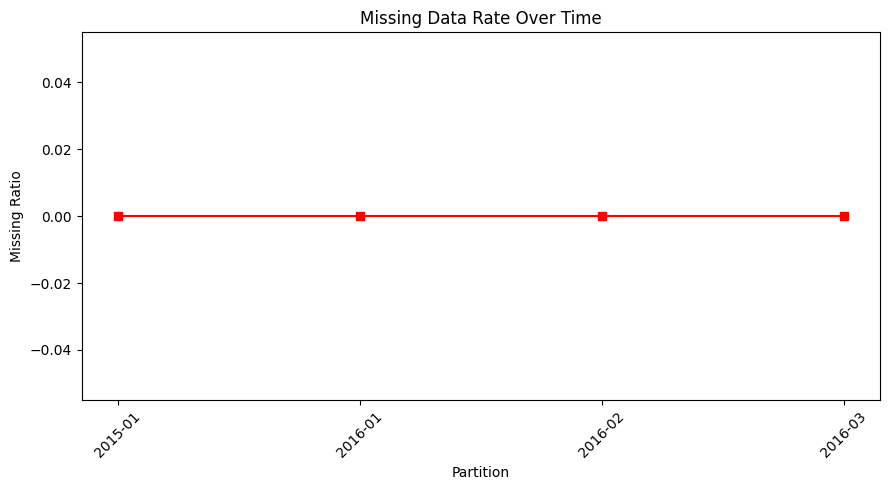

In [4]:
## Missingness Drift
plt.figure(figsize=(9, 5))
plt.plot(
    ingest_df["partition"],
    ingest_df["missing_rate"],
    marker="s",
    color="red"
)
plt.xticks(rotation=45)
plt.title("Missing Data Rate Over Time")
plt.ylabel("Missing Ratio")
plt.xlabel("Partition")
plt.tight_layout()
plt.show()


In [5]:

## Feature Distribution Drift (Wasserstein)
base_partition = ingest_df["partition"].iloc[0]
base_df = df[df["partition"] == base_partition]

numeric_cols = ["trip_distance", "fare_amount", "total_amount", "passenger_count"]

drift_records = []

for p, g in df.groupby("partition"):
    if p == base_partition:
        continue
    for col in numeric_cols:
        try:
            dist = wasserstein_distance(
                base_df[col].dropna(),
                g[col].dropna()
            )
        except Exception as e:
            dist = np.nan
        drift_records.append({
            "partition": p,
            "feature": col,
            "wasserstein_distance": dist
        })

drift_df = pd.DataFrame(drift_records)
gc.collect()
drift_df.head()


,partition,feature,wasserstein_distance
0,2016-01,trip_distance,0.126027
1,2016-01,fare_amount,0.600095
2,2016-01,total_amount,0.859165
3,2016-01,passenger_count,0.004968
4,2016-02,trip_distance,0.089230


In [6]:
# Optional: chunked streaming drift computation (advanced, not executed)
# from scipy.stats import wasserstein_distance
# def compute_partition_stats(file, feature, chunksize=500_000):
#     values = []
#     for chunk in pd.read_csv(file, usecols=[feature], chunksize=chunksize):
#         values.append(chunk[feature].dropna().values)
#     return np.concatenate(values)

# Example usage (commented):
# vals = compute_partition_stats(files[0], 'trip_distance')


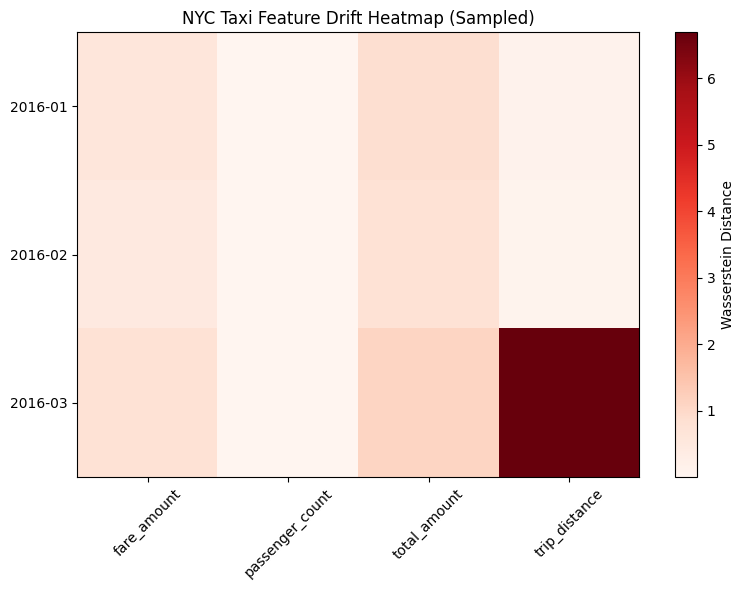

4439

In [7]:

## Drift Heatmap
pivot = drift_df.pivot(
    index="partition",
    columns="feature",
    values="wasserstein_distance"
)

plt.figure(figsize=(8, 6))
plt.imshow(pivot.values, aspect="auto", cmap="Reds")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.colorbar(label="Wasserstein Distance")
plt.title("NYC Taxi Feature Drift Heatmap (Sampled)")
plt.tight_layout()
plt.show()

drift_df.to_csv(
    "../results/tables/nyc_feature_drift.csv",
    index=False
)
gc.collect()